In [ ]:
#install libraries and dependencies
%pip install PyMuPDF
%pip install Pillow
%pip install pytesseract
%pip install python-dateutil
%pip install pdf2image

In [ ]:
%pip install --upgrade pytesseract
%pip install --upgrade opencv-python

In [ ]:
# import libs
try:
    from PIL import Image
except ImportError:
    import Image
import cv2
import pytesseract
import os
import numpy as np
import pandas as pd
import re
from pdf2image import convert_from_bytes


In [ ]:

# Some help functions 
def get_conf(page_gray):
    '''return a average confidence value of OCR result '''
    df = pytesseract.image_to_data(page_gray,output_type='data.frame')
    df.drop(df[df.conf==-1].index.values,inplace=True)
    df.reset_index()
    return df.conf.mean()
  
def deskew(image):
    '''deskew the image'''
    gray = cv2.bitwise_not(image)
    temp_arr = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(temp_arr > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated


In [24]:

# Assuming file_list is already defined correctly
PATH = 'file_path'
# Set the poppler_path variable
poppler_path = r'poppler_file_path'
# Set the tesseract variable
pytesseract.pytesseract.tesseract_cmd = r'tesseract_file_path'

# Your file_list definition here, for example:
file_list = [file for file in os.listdir(PATH) if file.endswith('.pdf')]

def process_page(page):
    try:
        # Transfer image of pdf_file into array
        page_arr = np.array(page)
        # Transfer into grayscale
        page_arr_gray = cv2.cvtColor(page_arr, cv2.COLOR_BGR2GRAY)
        # Deskew the page
        page_deskew = deskew(page_arr_gray)
        # Cal confidence value
        page_conf = get_conf(page_deskew)
        # Extract string 
        # Extract string
        d = pytesseract.image_to_data(page_deskew, output_type=pytesseract.Output.DICT)
        d_df = pd.DataFrame.from_dict(d)
        # Get block number
        block_num = int(d_df.loc[d_df['level'] == 2, 'block_num'].max())
        # Drop header and footer by index
        header_index = d_df[d_df['block_num'] == 1].index.values
        footer_index = d_df[d_df['block_num'] == block_num].index.values
        # Combine text in dataframe, excluding header and footer regions
        text = ' '.join(d_df.loc[(d_df['level'] == 5) & (~d_df.index.isin(header_index) & ~d_df.index.isin(footer_index)), 'text'].values)
        return page_conf, text
    except Exception as e:
        ## If can't extract then give some notes into df
        if hasattr(e, 'message'):
            return -1, e.message
        else:
            return -1, str(e)

OCR_dic = {}
for file in file_list:
    # Convert pdf into image
    pdf_file = convert_from_bytes(open(os.path.join(PATH, file), 'rb').read(), poppler_path=poppler_path)
    # Create a df to save each pdf's text
    pages_df = pd.DataFrame(columns=['conf', 'text'])
    for (i, page) in enumerate(pdf_file):
        page_conf, page_text = process_page(page)
        pages_df = pd.concat([pages_df, pd.DataFrame({'conf': page_conf, 'text': page_text}, index=[i])])
    # Save df into a dict with filename as key        
    OCR_dic[file] = pages_df
    print('{} is done'.format(file))


code_of_business_conduct_en.pdf is done


In [25]:
OCR_dic[file_list[0]]

,conf,text
0,76.933501,"OPANZG = es SN Nestle Good Food, Good Life Cod..."
1,93.702356,Board of Directors and Executive Board of Nest...
2,95.342851,"Introduction Since its founding, Nestlé’s bu..."
3,95.799846,"Compliance with laws, rules and regulations ..."
4,95.122420,outside engagements and activities Outside of ...
5,95.766294,Employees shall not compete with the Company. ...
6,95.763023,Nestlé is prepared to compete successfully in ...
7,95.920014,Employees must never engage in fraudulent or a...
8,95.877991,"ns following, whatever the value involved: E..."
9,95.128513,It is each employee's respons: full compliance...


Remove Header and Footer
After displaying the result, it seems that the header was included and it may not be wanted or required. Here I will show a simple code to exclude certain contents from our extraction results by using pytesseract.image_to_data syntax, which generates meta-data like box boundaries, confidence and other information.

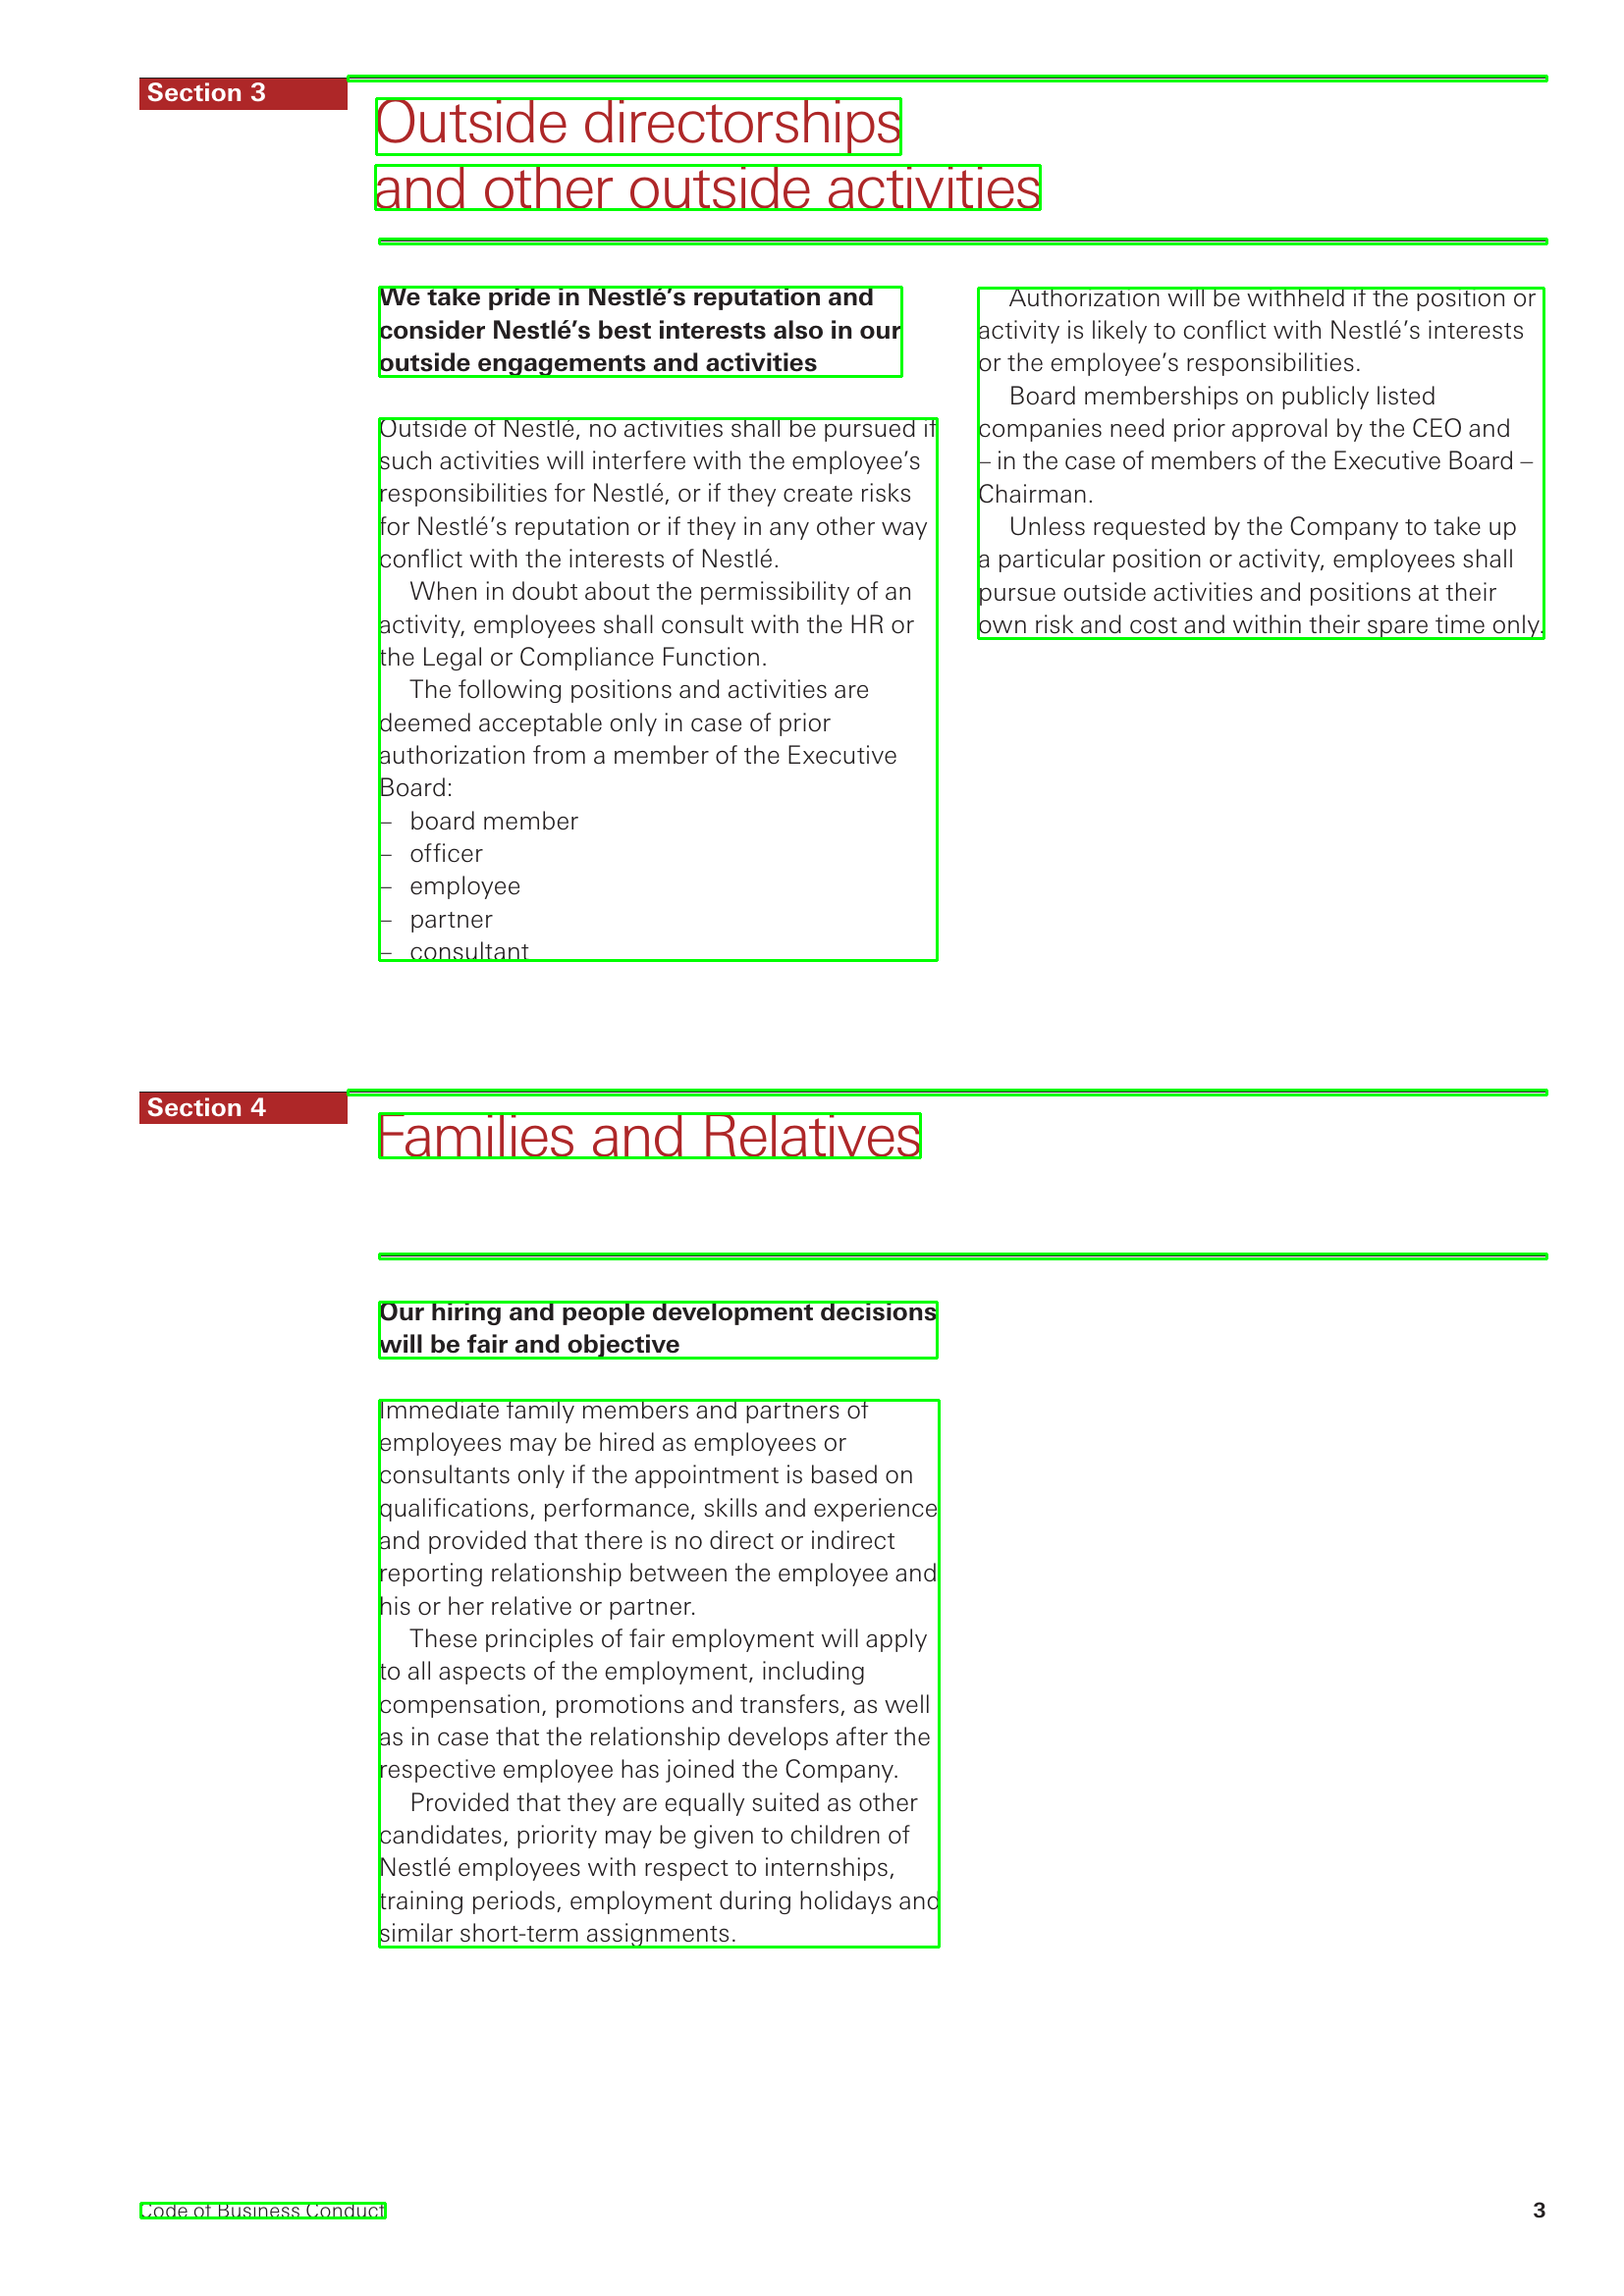

In [26]:
page_arr = np.asarray(pdf_file[4])

page_arr_gray = cv2.cvtColor(page_arr,cv2.COLOR_BGR2GRAY)

d = pytesseract.image_to_data(page_arr_gray,output_type=pytesseract.Output.DICT)

d_df = pd.DataFrame.from_dict(d)

n_boxes = len(d['text'])

for i in range(n_boxes):
    # level ==2 : show all the blocks recognized by tesseract 
    if d['level'][i] ==2:
        
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        # draw green lines on boxes
        img = cv2.rectangle(page_arr, (x, y), (x + w, y + h), (0, 255, 0), 2)

Image.fromarray(img)

In [27]:
d_df[d_df['level']==2]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
1,2,1,1,0,0,0,354,77,1221,5,-1,
5,2,1,2,0,0,0,383,100,534,57,-1,
10,2,1,3,0,0,0,382,168,677,45,-1,
17,2,1,4,0,0,0,386,243,1189,5,-1,
21,2,1,5,0,0,0,386,292,532,91,-1,
44,2,1,6,0,0,0,386,426,568,552,-1,
158,2,1,7,0,0,0,996,293,576,357,-1,
249,2,1,8,0,0,0,354,1110,1221,5,-1,
253,2,1,9,0,0,0,386,1134,551,45,-1,
259,2,1,10,0,0,0,386,1277,1189,5,-1,
